## BENDERS DECOMPOSITION METHOD
### Prepared by Bikey SERANILLA

In [1]:
import gurobipy as gp
from gurobipy import GRB
from numpy.random import randint, binomial
import numpy as np
from math import sqrt
from seaborn import distplot
from math import inf, isclose
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ipynb.fs.full.Parameters_Deterministic import *

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-23


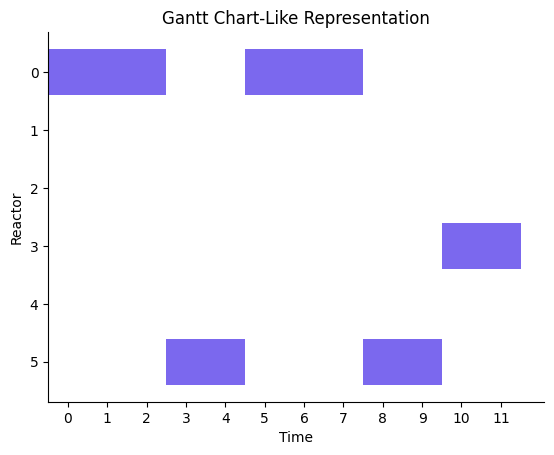

In [2]:
# MASTER PROBLEM
masterProblem = gp.Model()
masterProblem.Params.LogToConsole = 0
masterProblem.ModelSense = GRB.MINIMIZE
y = masterProblem.addVars(RT, vtype=GRB.BINARY, name='y')
v = masterProblem.addVars(RT, vtype=GRB.BINARY, name='v')
e = masterProblem.addVars(RT, vtype=GRB.BINARY, name='e_o')
e_e = masterProblem.addVars(RT, vtype=GRB.BINARY, name='e_e')
V = masterProblem.addVar(lb=0, name='V')
masterProblem.setObjective(V + gp.quicksum(y[(r,t)] for r in range(R) for t in range(T)))
#Constraints
masterProblem.addConstr(V >= 0)
for t in range(T):
    # one reactor always on
    masterProblem.addConstr(gp.quicksum(y[(r,t)] for r in range(R)) >= 1)

for t in range(T):
        # Start-Up Auxulliary Constraint
    if t==0:
        masterProblem.addConstrs(v[(r,t)] >= y[(r,t)] - 0 for r in range(R))
    else:
        masterProblem.addConstrs(v[(r,t)] >= y[(r,t)] - y[(r,t-1)] for r in range(R))

for r in range(R):
    # Amount of On-Cycles Constraint
    masterProblem.addConstr(gp.quicksum(v[(r,t)] for t in range(T)) >= s_min[r])
    masterProblem.addConstr(gp.quicksum(v[(r,t)] for t in range(T)) <= s_max[r])

    # Amount of Off-Cycles Constraint
    masterProblem.addConstr(gp.quicksum(e[(r,t)] for t in range(T)) >= b_min[r])
    
    for t in range(l_min[r],T):
        # Minimum Duration Constraint
        masterProblem.addConstr(gp.quicksum(v[(r,i)] for i in range(t-l_min[r],t)) <= y[(r,t)])
    for t in range(l_max[r]+1,T):
        # Maxinum Duration Constraint
        masterProblem.addConstr(gp.quicksum(y[(r,i)] for i in range(t-l_max[r]-1,t)) <= l_max[r])
    for t in range(q_min[r],T):
        # Minimum Duration of Outtage Constraint
        masterProblem.addConstr(gp.quicksum(e[(r,i)] for i in range(t-q_min[r],t)) <= 1 - y[(r,t)])
    for t in range(T):
        # Shut Down Auxiliary Constraint
        if t==0:
            masterProblem.addConstr(e[(r,t)] >= 0 - y[(r,t)])
        else:
            masterProblem.addConstr(e[(r,t)] >= y[(r,t-1)] - y[(r,t)])
    for t in range(T):
        # Start Up and Shut Down Test in Python
        if t==0:
            masterProblem.addConstr(y[(r,t)] - 0 == v[(r,t)] - e[(r,t)])
        else:
            masterProblem.addConstr(y[(r,t)] - y[(r,t-1)] == v[(r,t)] - e[(r,t)])

masterProblem.update()
masterProblem.optimize()

solution_1_1 = masterProblem.getAttr('X', y)
solution_1_2 = masterProblem.getAttr('X', v)
solution_1_3 = masterProblem.getAttr('X', e)
df = tupledict_to_dataframe(solution_1_1)
df_2 = tupledict_to_dataframe(solution_1_2)
df_3 = tupledict_to_dataframe(solution_1_3)
# print(df)
# print(df_2)
# print(df_3)

p = plotting(df)

In [ ]:
# SUBPROBLEM
def subProblem(y):
    subProblem = Model()
    subProblem.Params.LogToConsole = 0
    subProblem.ModelSense = GRB.MINIMIZE
    x1 = subProblem.addVar(lb=0, name='x1')
    x2 = subProblem.addVar(lb=0, name='x2')
    subProblem.addConstr(x1 + 2*x2 + y >= 2, name="constr1")
    subProblem.addConstr(2*x1 - x2 + 3*y >= 5, name="constr2")
    subProblem.setObjective(5*x1 + 6*x2)
    subProblem.optimize()
    x_star = subProblem.getAttr('X', [x1, x2])
    u_star = subProblem.Pi
    UB = subProblem.ObjVal

    return x_star, u_star, UB

In [ ]:
#Sets
R = 6
P = 4
M = 5

#Model
m = Model()
m.ModelSense = GRB.MAXIMIZE

#Decision Variables
x_rp = m.addVars(R, P, lb=0, name='x_rp')
x_pm = m.addVars(P, M, lb=0, name='x_pm')
shortage = m.addVars(M, lb=0, ub=marketdf['Demand'].values, name='shortage')
surplus = m.addVars(M, lb=0, ub=surpluscap.values, name='surplus')

#Objective Fucntion
m.setObjective(sum((surplus[i]*mdemand[i,0] + (shortage[i]*mdemand[i,1])/marketdf.iloc[i, 1]) for i in range(5)))

#Constraints
for r in range(R):
# reactor capacity
    m.addConstr(gp.quicksum(x_rp[(r,p)] for p in range(P)) <= rdata['Capacity'][r])

for p in range(P):
# processor capacity
    m.addConstr(gp.quicksum(x_pm[(p,m)] for m in range(M)) <= pdata['Capacity'][p])

for n in range(M):
# market capacity
    m.addConstr(mdata['Demand'][n] - shortage[n] + surplus[n] <= mdata['Capacity'][n])

# processor balance
m.addConstrs(gp.quicksum(x_pm[(p,m)] for m in range(M)) <= x_rp.prod(rpdict, '*', p) for p in range(4))

# market balance
m.addConstrs(mdata['Demand'][n] - shortage[n] + surplus[n] <= x_pm.prod(pmdict, '*', n) for n in range(5))

m.update()
m.optimize()

solution_2_1 = m.getAttr('X', x_rp)
solution_2_2 = m.getAttr('X', x_pm)

In [ ]:
# BENDERS DECOMPOSITION ALGORITHM

ε = 0.0001
UB = math.inf
LB = 0
bound = UB - LB
k = 0
y_k = [0]

#Parameters
b = np.array((2, 5))
F_y = np.array((y, 3*y))
    
    
while bound > ε:
    k = k + 1

    #Step 1 : Set y = y_k
    Y = y_k[0]

    #Step 2: Solve Subproblem
    SP = subProblem(Y)

    #Step 3: Update UB
    UB = SP[2]
    bound = UB - LB

    #Step 4: Add a Benders cut
    b = np.array((2, 5))
    F_y = np.array((y, 3*y))
    c = (b-F_y).T*SP[1]
    CUT = c[0] + c[1]

    masterProblem.addConstr(V >= CUT)
    
    #Step 5: Solve the Master Problem
    masterProblem.optimize()
    LB = masterProblem.ObjVal
    y_k = masterProblem.getAttr('X', [y])

    bound = UB - LB

    print(k,": Bound = [",UB, " ,",LB, "]") 

print("Optimal Objective Function: ", LB)
print("Optimal Value of x1: ", SP[1][0])
print("Optimal Value of x2: ", int(SP[1][1]))
print("Optimal Value of y: ", y_k)

In [ ]:
# # BENDERS DECOMPOSITION ALGORITHM

# # Step 1: Initialization
# # Step 2: Solve Subproblem
# i = subProblem(y = 0)

# b = np.array((3, 4))
# F_y = np.array((y, 3*y))
# c = (b-F_y).T*i[1]
# CUT = c[0] + c[1]
# print(CUT)
# masterProblem.addConstraint(V >= CUT)
# masterProblem.solve()
# a = masterProblem.getSolution(y)
# b = masterProblem.getObjVal()